In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from division_aggregation_function import division_aggregation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv("index.csv")
hosp = pd.read_csv("hospitalizations.csv")
epi = pd.read_csv("epidemiology.csv")
vax = pd.read_csv("vaccinations.csv")
emrg = pd.read_csv("lawatlas-emergency-declarations.csv")
weather = pd.read_csv('weather.csv')
govresp = pd.read_csv('oxford-government-response.csv')

In [6]:
epi_us = epi[epi.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
hosp_us = hosp[hosp.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
vax_us = vax[vax.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
emrg_us = emrg[emrg.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
weather_us = weather[weather.location_key.isin(data[data.country_name == 'United States of America'].location_key)]
govresp_us = govresp[govresp.location_key.isin(data[data.country_name == 'United States of America'].location_key)]

In [7]:
terrs = ['US', 'AS', 'GU', 'MP', 'PR', 'VI']
epi_f = epi_us[(epi_us.location_key.str.len() <= 5) & ~(epi_us.location_key.isin(terrs))]
hosp_f = hosp_us[(hosp_us.location_key.str.len() <= 5) & ~(hosp_us.location_key.isin(terrs))]
vax_f = vax_us[(vax_us.location_key.str.len() <= 5) & ~(vax_us.location_key.isin(terrs))]
emrg_f = emrg_us[(emrg_us.location_key.str.len() <= 5) & ~(emrg_us.location_key.isin(terrs))]
weather_f = weather_us[(weather_us.location_key.str.len() <= 5) & ~(weather_us.location_key.isin(terrs))]
govresp_f = govresp_us[(govresp_us.location_key.str.len() <= 5) & ~(govresp_us.location_key.isin(terrs))]

In [28]:
data1 = pd.merge(epi_f, hosp_f, on=['date', 'location_key']).merge(weather_f, on=['date', 'location_key']).merge(govresp_f, on=['date', 'location_key'])
vax_f = vax_f[vax_f.columns[(vax_f.isna().sum()/len(vax_f) < 0.8).values]]
data1 = pd.merge(data1, vax_f, on = ['date', 'location_key'], how = 'left')

In [ ]:
data1.loc[data1['date'] < min(vax_f.date), ['new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated',
       'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered',
       'cumulative_vaccine_doses_administered',
       'new_persons_fully_vaccinated_pfizer',
       'cumulative_persons_fully_vaccinated_pfizer',
       'new_vaccine_doses_administered_pfizer',
       'cumulative_vaccine_doses_administered_pfizer',
       'new_persons_fully_vaccinated_moderna',
       'cumulative_persons_fully_vaccinated_moderna',
       'new_vaccine_doses_administered_moderna',
       'cumulative_vaccine_doses_administered_moderna',
       'new_persons_fully_vaccinated_janssen',
       'cumulative_persons_fully_vaccinated_janssen',
       'new_vaccine_doses_administered_janssen',
       'cumulative_vaccine_doses_administered_janssen']] = 0

In [ ]:
data_all = data1[data1.columns[(data1.isna().sum()/len(data1) < 0.5).values]]

In [ ]:
data_all.to_csv('covid_data1.csv')

In [37]:
data_all = pd.read_csv('/Users/RJS/Desktop/STAT 390/Stat390-Project/data/covid_data1.csv')
data_all['region'] = data_all['location_key'].apply(division_aggregation)
data_all = data_all[data_all.columns[(data_all.isna().sum()/len(data_all) <= 0.1).values]]

In [63]:
y_data = data_all[['date', 'location_key', 'region', 'new_confirmed']]
x_data = data_all.drop(columns = ['location_key', 'date', 'new_confirmed'])
xddum = pd.get_dummies(x_data)
scaler = StandardScaler()
scaledx = scaler.fit_transform(xddum)

In [39]:
datanum = xddum.copy()
mice = IterativeImputer(max_iter = 50, random_state = 0)
imputedvals = mice.fit_transform(datanum)
imputed_datanum1 = pd.DataFrame(imputedvals, columns = xddum.columns)

In [64]:
datanum = scaledx.copy()
knn = KNNImputer(n_neighbors = 100)
imputedvals2 = knn.fit_transform(datanum)
knn_datanum = pd.DataFrame(imputedvals2, columns = xddum.columns)

Text(0.5, 1.0, 'New Persons Vaccinated - Moderna Distribution')

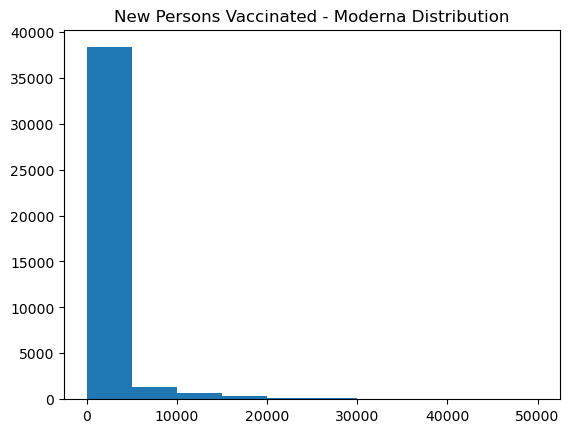

In [43]:
plt.hist(data_all.new_persons_fully_vaccinated_moderna, range = (0, 50000))
plt.title('New Persons Vaccinated - Moderna Distribution')

Text(0.5, 1.0, 'MICE Imputation Value Distribution')

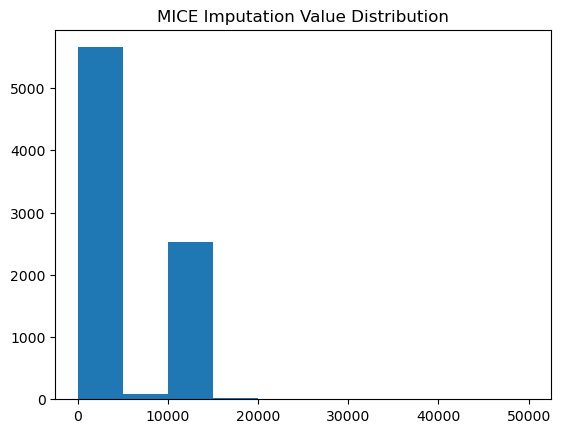

In [43]:
plt.hist(imputed_datanum1[data_all.isna().any(axis = 1)].new_persons_fully_vaccinated_moderna, range = (0, 50000))
plt.title('MICE Imputation Value Distribution')

Text(0.5, 1.0, 'KNN Imputation Value Distribution')

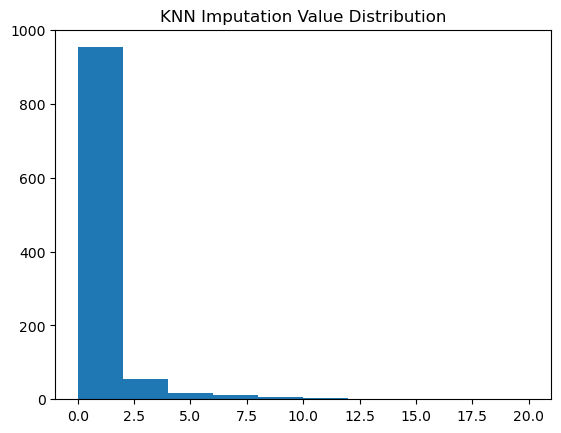

In [53]:
plt.hist(knn_datanum[data_all.isna().any(axis = 1)].new_persons_fully_vaccinated_moderna, range = (0, 20))
plt.title('KNN Imputation Value Distribution')

In [65]:
xdatanew = pd.DataFrame(scaler.inverse_transform(knn_datanum), columns = xddum.columns)
xdatanew.drop(columns = xdatanew.columns[-9:], inplace = True)
data_all = pd.concat([y_data, xdatanew], axis = 1)

In [68]:
numofstates = {
    "New England": 6,
    "Mid-Atlantic": 3,
    "East North Central": 5,
    "West North Central": 7,
    "South Atlantic": 9,
    "East South Central": 4,
    "West South Central": 4,
    "Mountain": 8,
    "Pacific": 5
}

In [69]:
def groupfilter(group):
    region = group.name[0]
    numstates = numofstates[region]
    return group['location_key'].nunique() == numstates

In [70]:
filtered_data = data_all.groupby(['region', 'date']).filter(groupfilter)

In [71]:
filtered_data.groupby(['region', 'date']).size()

region              date      
East North Central  2020-03-05    5
                    2020-03-06    5
                    2020-03-07    5
                    2020-03-08    5
                    2020-03-09    5
                                 ..
West South Central  2022-06-30    4
                    2022-07-01    4
                    2022-07-02    4
                    2022-07-03    4
                    2022-07-04    4
Length: 7654, dtype: int64

In [72]:
grouped = filtered_data.groupby(['region', 'date'])

In [74]:
regional_multi = grouped.agg({'new_confirmed': 'sum', 'new_deceased': 'sum',
       'cumulative_confirmed': 'sum', 'cumulative_deceased': 'sum', 
       'new_hospitalized_patients': 'sum', 'cumulative_hospitalized_patients': 'sum',
       'current_hospitalized_patients': 'sum', 'current_intensive_care_patients': 'sum',
       'new_persons_vaccinated': 'sum', 'cumulative_persons_vaccinated': 'sum',
       'new_persons_fully_vaccinated': 'sum', 'cumulative_persons_fully_vaccinated': 'sum',
       'new_vaccine_doses_administered': 'sum',
       'cumulative_vaccine_doses_administered': 'sum',
       'new_persons_fully_vaccinated_pfizer': 'sum',
       'cumulative_persons_fully_vaccinated_pfizer': 'sum',
       'new_vaccine_doses_administered_pfizer': 'sum',
       'cumulative_vaccine_doses_administered_pfizer': 'sum',
       'new_persons_fully_vaccinated_moderna': 'sum',
       'cumulative_persons_fully_vaccinated_moderna': 'sum',
       'new_vaccine_doses_administered_moderna': 'sum',
       'cumulative_vaccine_doses_administered_moderna': 'sum',
       'new_persons_fully_vaccinated_janssen': 'sum',
       'cumulative_persons_fully_vaccinated_janssen': 'sum',
       'new_vaccine_doses_administered_janssen': 'sum',
       'cumulative_vaccine_doses_administered_janssen': 'sum',
       'rainfall_mm': 'sum', 
       'average_temperature_celsius': 'mean', 'dew_point': 'mean',
       'relative_humidity': 'mean', 'school_closing': 'mean', 'workplace_closing': 'mean',
       'cancel_public_events': 'mean', 'restrictions_on_gatherings': 'mean',
       'public_transport_closing': 'mean', 'stay_at_home_requirements': 'mean',
       'restrictions_on_internal_movement': 'mean', 'international_travel_controls': 'mean',
       'income_support': 'mean', 'debt_relief': 'mean', 'public_information_campaigns': 'mean',
       'testing_policy': 'mean', 'contact_tracing': 'mean', 'facial_coverings': 'mean',
       'vaccination_policy': 'mean', 'stringency_index': 'mean', 
       'minimum_temperature_celsius': 'min', 
       'maximum_temperature_celsius': 'max'})

In [77]:
regional_multi.to_csv('../data/regional_multivariate_data.csv')